In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Charger et préparer les données fusionnées
df_final = pd.read_csv("data_fusionner_netoyeer.csv")
df_final['date'] = pd.to_datetime(df_final['date'])
df_final = df_final.set_index('date').sort_index()

--- Statistiques Descriptives ---
             NDVI  NDVI_smoothed  precipitation  temperature          RH
count  329.000000     325.000000     329.000000   329.000000  329.000000
mean     0.115853       0.116003       0.244832    23.675857   33.327647
std      0.038485       0.019581       0.837372     7.319718   11.613460
min      0.069456       0.088910       0.000000     5.807220   11.585891
25%      0.084347       0.101844       0.000000    17.517000   24.177973
50%      0.106093       0.109803       0.000000    24.337928   31.977711
75%      0.132948       0.125935       0.074760    29.456844   41.698876
max      0.253773       0.184251      10.596684    37.471479   71.086975


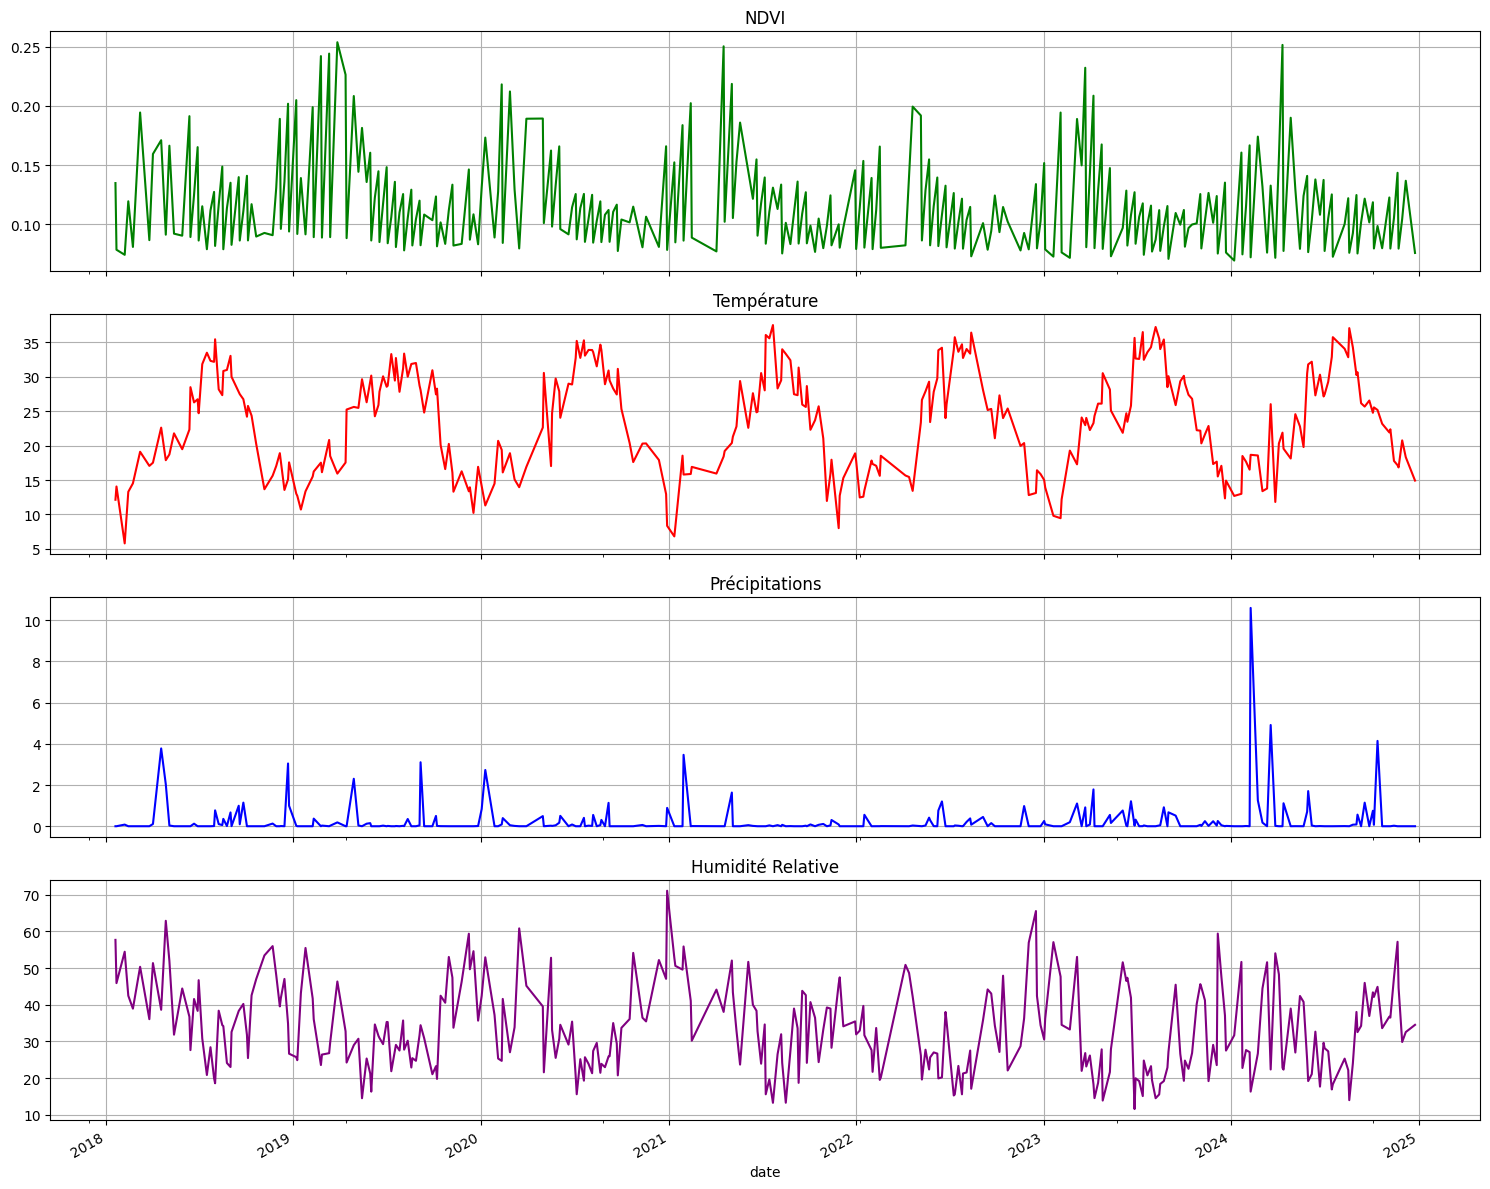

In [3]:
# Statistiques descriptives pour toutes les variables
print("--- Statistiques Descriptives ---")
print(df_final.describe())

# Visualisation des 4 séries temporelles
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

df_final['NDVI'].plot(ax=axes[0], title='NDVI', color='green')
axes[0].grid(True)
df_final['temperature'].plot(ax=axes[1], title='Température', color='red')
axes[1].grid(True)
df_final['precipitation'].plot(ax=axes[2], title='Précipitations', color='blue')
axes[2].grid(True)
df_final['RH'].plot(ax=axes[3], title='Humidité Relative', color='purple')
axes[3].grid(True)

plt.tight_layout()
plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller

# Test Augmented Dickey-Fuller (ADF) sur l'NDVI
adf_result = adfuller(df_final['NDVI'])
print(f'--- Test de Stationnarité (ADF) sur l\'NDVI ---')
print(f'p-value: {adf_result[1]}')
if adf_result[1] > 0.05:
    print("Conclusion : L'NDVI est probablement non-stationnaire.")
else:
    print("Conclusion : L'NDVI est probablement stationnaire.")

--- Test de Stationnarité (ADF) sur l'NDVI ---
p-value: 0.00048445159334313976
Conclusion : L'NDVI est probablement stationnaire.


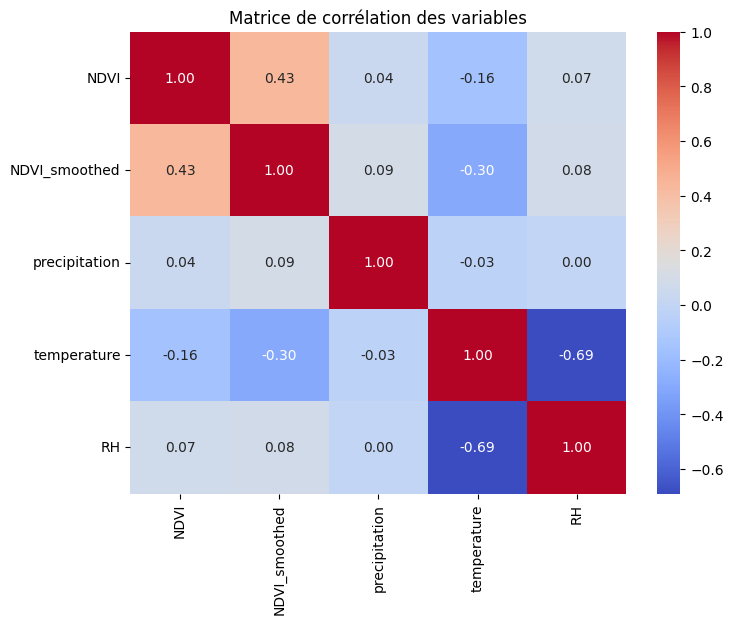


--- Analyse de l'autocorrélation de l'NDVI ---


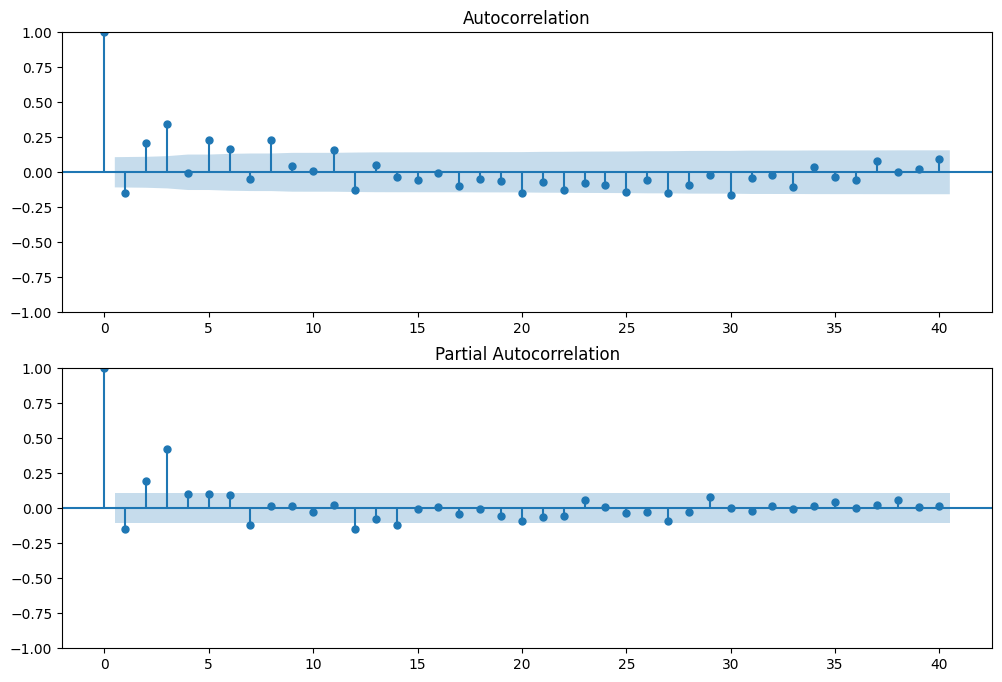

In [5]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Matrice de corrélation pour voir les liens entre les variables
correlation_matrix = df_final.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation des variables')
plt.show()

# Graphiques ACF/PACF pour justifier la création de "lags" (valeurs passées)
print("\n--- Analyse de l'autocorrélation de l'NDVI ---")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_final['NDVI'], ax=ax1, lags=40)
plot_pacf(df_final['NDVI'], ax=ax2, lags=40)
plt.show()

In [6]:
# Création des caractéristiques (Features)
df_model = df_final.copy()
df_model['jour_annee'] = df_model.index.dayofyear
df_model['mois'] = df_model.index.month
for lag in range(1, 8): # On crée 7 jours de lags
    df_model[f'ndvi_lag_{lag}'] = df_model['NDVI'].shift(lag)
df_model = df_model.dropna()

# Définir les features (X) et la cible (y)
features = [col for col in df_model.columns if col != 'NDVI']
target = 'NDVI'
X = df_model[features]
y = df_model[target]

# Diviser les données : test sur l'année 2024
split_date = '2024-01-01'
X_train = X[X.index < split_date]
y_train = y[y.index < split_date]
X_test = X[X.index >= split_date]
y_test = y[y.index >= split_date]

# Créer et entraîner le modèle XGBoost
print("--- Entraînement du modèle XGBoost ---")
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    early_stopping_rounds=50, # Arrêt précoce pour éviter le surapprentissage
    random_state=42
)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
print("✅ Modèle entraîné.")

--- Entraînement du modèle XGBoost ---
✅ Modèle entraîné.



--- Validation sur 2024 ---
MAE: 0.0205
RMSE: 0.0265


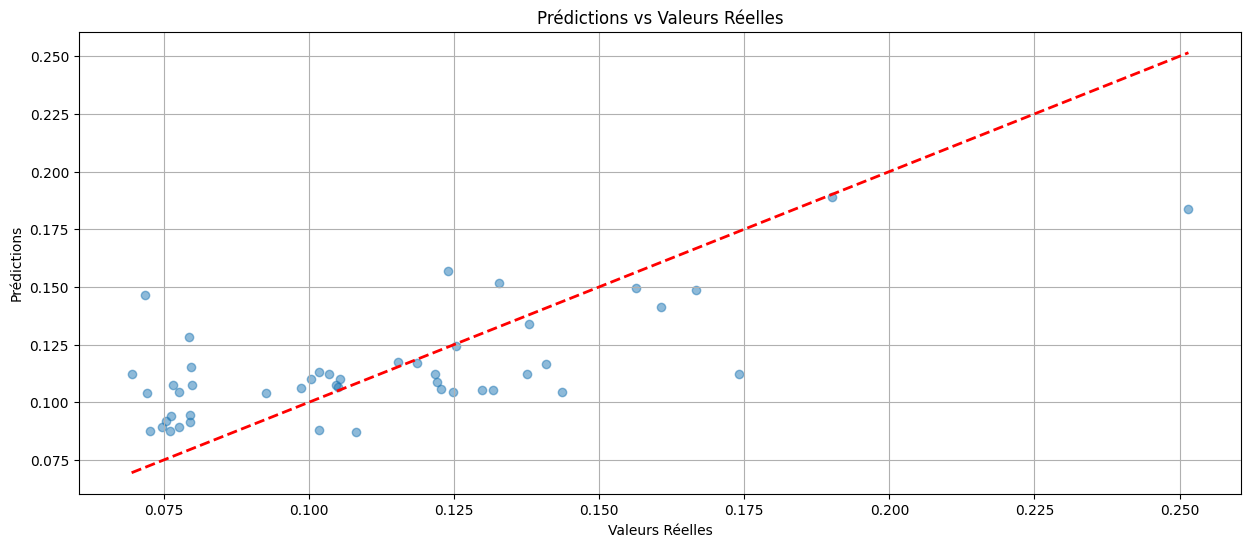

In [7]:
# Prédictions sur le jeu de test (2024)
predictions = model.predict(X_test)

# Métriques d'erreur
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'\n--- Validation sur 2024 ---')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

# Analyse des résidus
residuals = y_test - predictions
plt.figure(figsize=(15, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Prédictions vs Valeurs Réelles')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.grid(True)
plt.show()

✅ Fichier de données fusionnées chargé.
--- Entraînement du modèle XGBoost ---
✅ Modèle entraîné.

--- Prédictions Futures ---
Ré-entraînement du modèle sur toutes les données...
✅ Modèle final prêt.
🔮 Génération des prédictions pour l'année suivante...
✅ Prédictions générées.


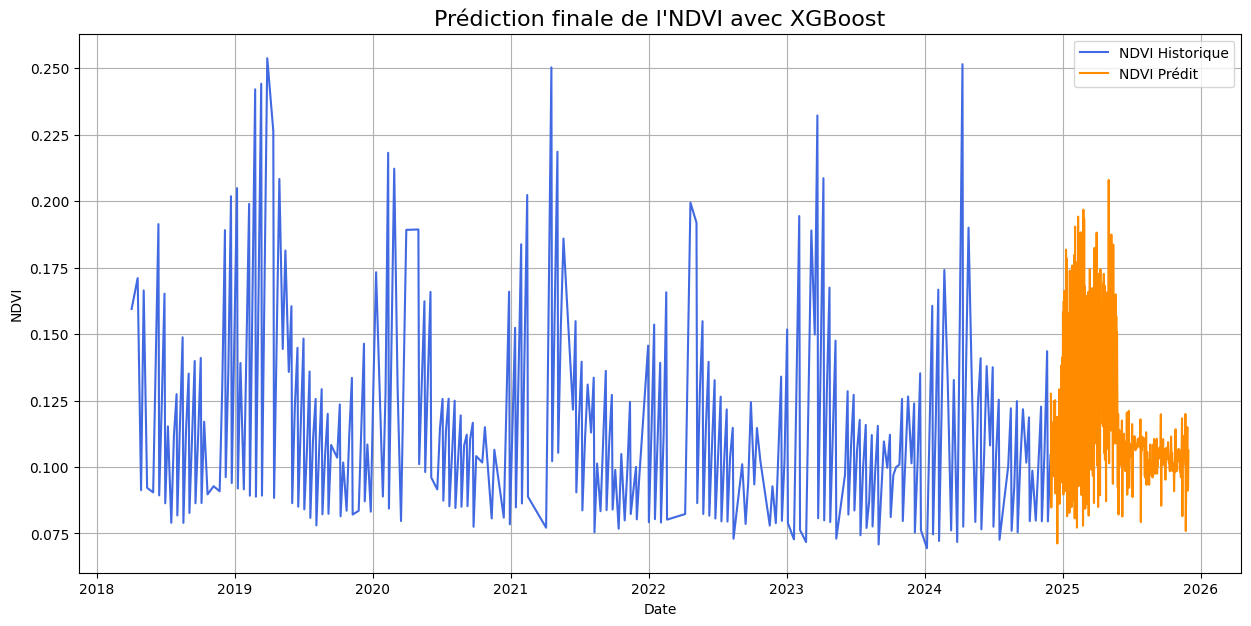

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# --- ÉTAPE 1: CHARGEMENT ET PRÉPARATION DES DONNÉES ---
try:
    df_final = pd.read_csv("data_fusionner_netoyeer.csv")
    print("✅ Fichier de données fusionnées chargé.")
except FileNotFoundError:
    print("❌ ERREUR : Le fichier 'data_fusionner_netoyeer.csv' est introuvable.")
    exit()

df_final['date'] = pd.to_datetime(df_final['date'])
df_final = df_final.set_index('date').sort_index()

# --- ÉTAPE 2: CRÉATION DES CARACTÉRISTIQUES (FEATURE ENGINEERING) ---
df_model = df_final.copy()
df_model['jour_annee'] = df_model.index.dayofyear
df_model['mois'] = df_model.index.month
# On utilise 7 lags car c'est une bonne pratique pour les données quotidiennes
for lag in range(1, 8):
    df_model[f'ndvi_lag_{lag}'] = df_model['NDVI'].shift(lag)
df_model = df_model.dropna()

# --- ÉTAPE 3: ENTRAÎNEMENT DU MODÈLE XGBOOST ---

# --- LA CORRECTION EST ICI ---
# On définit explicitement la liste des caractéristiques pour éviter les colonnes non désirées.
features = [
    'temperature', 'precipitation', 'RH',          # Facteurs climatiques
    'jour_annee', 'mois',                          # Facteurs temporels
    'ndvi_lag_1', 'ndvi_lag_2', 'ndvi_lag_3', 'ndvi_lag_4', # Lags de NDVI
    'ndvi_lag_5', 'ndvi_lag_6', 'ndvi_lag_7'
]
target = 'NDVI'

X = df_model[features]
y = df_model[target]

# Diviser les données : test sur l'année 2024
split_date = '2024-01-01'
X_train = X[X.index < split_date]
y_train = y[y.index < split_date]
X_test = X[X.index >= split_date]
y_test = y[y.index >= split_date]

# Créer et entraîner le modèle
print("--- Entraînement du modèle XGBoost ---")
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    early_stopping_rounds=50,
    random_state=42
)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
print("✅ Modèle entraîné.")

# --- ÉTAPE 4: PRÉDICTIONS FUTURES (corrigé pour l'erreur précédente également) ---
print("\n--- Prédictions Futures ---")

# Récupérer les paramètres du modèle entraîné et retirer 'early_stopping_rounds'
final_params = model.get_params()
final_params.pop('early_stopping_rounds', None)

# Créer le modèle final et le ré-entraîner sur TOUTES les données
full_model = xgb.XGBRegressor(**final_params)
print("Ré-entraînement du modèle sur toutes les données...")
full_model.fit(X, y, verbose=False)
print("✅ Modèle final prêt.")

# Logique de prédiction récursive
last_date = df_model.index.max()
start_prediction_date = last_date + pd.Timedelta(days=1)
end_prediction_date = start_prediction_date + pd.Timedelta(days=364)
future_dates = pd.date_range(start=start_prediction_date, end=end_prediction_date, freq='D')
future_df = pd.DataFrame(index=future_dates)

# Remplir les données climatiques futures avec la moyenne historique
dayofyear_map = df_model.groupby(df_model.index.dayofyear)[['temperature', 'precipitation', 'RH']].mean()
if 366 in dayofyear_map.index and not future_df.index.is_leap_year.any():
    dayofyear_map.loc[365] = dayofyear_map.loc[[365, 366]].mean()
future_dayofyear = future_df.index.dayofyear
future_df[['temperature', 'precipitation', 'RH']] = dayofyear_map.reindex(future_dayofyear).values

future_df['jour_annee'] = future_df.index.dayofyear
future_df['mois'] = future_df.index.month

# Utiliser les 7 dernières valeurs connues pour initialiser les lags
last_known_lags = list(y.iloc[-7:])
predictions_future = []

print("🔮 Génération des prédictions pour l'année suivante...")
for date in future_df.index:
    # Créer les lags pour la prédiction du jour
    for i in range(1, 8):
        future_df.loc[date, f'ndvi_lag_{i}'] = last_known_lags[-i]

    # Prédire
    current_features = future_df.loc[[date]][features]
    prediction = full_model.predict(current_features)[0]
    predictions_future.append(prediction)

    # Mettre à jour l'historique des lags avec la nouvelle prédiction
    last_known_lags.append(prediction)
    last_known_lags.pop(0)

future_df['NDVI_predicted'] = predictions_future
print("✅ Prédictions générées.")

# --- ÉTAPE 5: VISUALISATION ---
plt.figure(figsize=(15, 7))
plt.plot(df_model.index, df_model['NDVI'], label='NDVI Historique', color='royalblue')
plt.plot(future_df.index, future_df['NDVI_predicted'], label='NDVI Prédit', linestyle='-', color='darkorange')
plt.title("Prédiction finale de l'NDVI avec XGBoost", fontsize=16)
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Définir le nom du fichier pour votre modèle
nom_du_fichier_modele = 'mon_modele_xgboost.json'

# Sauvegarder le modèle
full_model.save_model(nom_du_fichier_modele)

print(f"✅ Modèle XGBoost sauvegardé avec succès dans le fichier : {nom_du_fichier_modele}")
# --- FIN DE LA PARTIE À AJOUTER ---

✅ Modèle XGBoost sauvegardé avec succès dans le fichier : mon_modele_xgboost.json
